#Extraction of dataset

The ISIC datasets are extracted as Image and its corresponding binary mask pairs.

In [1]:
import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        if mode!='test':
          self.file_real = sorted(glob.glob(root + '/images/*.jpg'))
          self.file_gt = sorted(glob.glob(root+ '/gt/*.png'))
        else:
          self.file_real = sorted(glob.glob(root + '/images/*.jpg'))
          self.file_gt = []

    def __getitem__(self, index):

        img_A = Image.open(self.file_real[index % len(self.file_real)])
        
        seed = np.random.randint(2147483647)  # make a seed with numpy generator
        random.seed(seed)  # apply seed to img tranfsorms
        img_A = self.transform(img_A)
        
        img_B = None
        if len(self.file_gt)!=0:
          img_B = Image.open(self.file_gt[index % len(self.file_gt)])
          random.seed(seed)  # apply seed to target tranfsorms
          img_B = self.transform(img_B)

          return {'A': img_A, 'B':img_B}
        
        return {'A': img_A}

    def __len__(self):
        return len(self.file_real)

#Building the model

1. Unet Based Generator Model
2. CNN Based Pixel Discriminator Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import functools

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

##############################
#        Generator
##############################

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.0)
        self.down5 = UNetDown(512, 512, dropout=0.0)
        self.down6 = UNetDown(512, 512, dropout=0.0)
        self.down7 = UNetDown(512, 512, dropout=0.0)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.0)
        self.up1 = UNetUp(512, 512, dropout=0.0)
        self.up2 = UNetUp(1024, 512, dropout=0.0)
        self.up3 = UNetUp(1024, 512, dropout=0.0)
        self.up4 = UNetUp(1024, 512, dropout=0.0)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

##############################
#        Discriminator
##############################

class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc=4, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(PixelDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=2, padding=1, bias=False)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.net(img_input)

#Mounting Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
root_path = '/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN'
os.chdir(root_path)  

#Training the Generator Model without Discriminator

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch import optim
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch

class OptionsUNet:
  def __init__(self, epoch = 48, n_epochs = 50, dataset_name = "sgan", batch_size = 32, lr = 0.0001, b1 = 0.5, b2 = 0.999, decay_epoch = 1, n_cpu = 8, img_height = 256, img_width = 256, 
               channels = 3, sample_interval = 1, checkpoint_interval = 1, path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/"):
    self.epoch = epoch
    self.n_epochs = n_epochs
    self.dataset_name = dataset_name
    self.batch_size = batch_size
    self.lr = lr
    self.b1 = b1
    self.b2 = b2
    self.decay_epoch = decay_epoch
    self.n_cpu = n_cpu
    self.img_height = img_height
    self.img_width = img_width
    self.channels = channels
    self.sample_interval = sample_interval
    self.checkpoint_interval = checkpoint_interval
    self.path = path

    return 

file_unet = open("unet.txt","a")

opt = OptionsUNet()
print(opt)

os.makedirs('images/%s' % opt.dataset_name, exist_ok=True)
os.makedirs('saved_model/%s' % opt.dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion = nn.BCELoss()

criterion_pixelwise = torch.nn.L1Loss()

# Initialize network
Unet = GeneratorUNet()

if cuda:
    Unet = torch.nn.DataParallel(Unet).cuda()
    criterion.cuda()
    criterion_pixelwise.cuda()

if opt.epoch != 0:
    # Load pretrained models
    Unet.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model/sgan/generator_47.pth"))
else:
    # Initialize weights
    Unet.apply(weights_init_normal)

# Optimizers
optimizer = torch.optim.Adam(Unet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Configure dataloaders
transforms_ = [transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),] 
        
transforms_val = [transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]


train_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/train"
dataloader = DataLoader(ImageDataset(train_path, transforms_=transforms_), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)
print('len of train batch is: ', len(dataloader))

val_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val"
val_dataloader = DataLoader(ImageDataset(val_path, transforms_=transforms_val, mode='val'), batch_size=1, shuffle=True, num_workers=1)
print('len of val batch is: ', len(val_dataloader))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(batches_done, path):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs['A'].type(Tensor))
    real_B = Variable(imgs['B'].type(Tensor))
    pred_B = Unet(real_A)
    os.makedirs(os.path.join(path, 'images/%s/img/' % opt.dataset_name), exist_ok=True)
    os.makedirs(os.path.join(path, 'images/%s/gt/' % opt.dataset_name), exist_ok=True)
    os.makedirs(os.path.join(path, 'images/%s/pred/' % opt.dataset_name), exist_ok=True)
    save_image(real_A, os.path.join(path, 'images/%s/img/%s_image.png' % (opt.dataset_name, batches_done)), nrow=3, normalize=True, scale_each=True)
    save_image(real_B, os.path.join(path, 'images/%s/gt/%s_image.png' % (opt.dataset_name, batches_done)), nrow=3, normalize=True, scale_each=True)
    save_image(pred_B, os.path.join(path, 'images/%s/pred/%s_image.png' % (opt.dataset_name, batches_done)), nrow=3, normalize=True, scale_each=True)

prev_time = time.time()


for epoch in range(opt.epoch, opt.n_epochs):
    m_loss = 0
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch['A'].type(Tensor))
        real_B = Variable(batch['B'].type(Tensor))

        # ------------------
        #  Train Network
        # ------------------

        optimizer.zero_grad()

        # loss
        predicted = Unet(real_A)
        predicted = F.sigmoid(predicted)
        loss = criterion(predicted, real_B)

        loss.backward()

        optimizer.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        m_loss+=loss.item()
        
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [loss: %f] ETA: %s" %
                         (epoch, opt.n_epochs,
                          i, len(dataloader),
                          loss.item(),
                          time_left))

        # If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            sample_images(batches_done, opt.path)
    file_unet.write(str(m_loss/opt.batch_size)+"\n")
    
    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(Unet.state_dict(), os.path.join(opt.path, 'saved_model/%s/generator_%d.pth' % (opt.dataset_name, epoch)))
file_unet.close()

len of train batch is:  82
len of val batch is:  100


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[Epoch 49/50] [Batch 81/82] [loss: -0.392932] ETA: 0:00:02.799351

Validation of the Generator Model

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


len of val batch is:  100
Average testing time is  4.738240525838919
Average DICE COEFFICIENT:  0.877515117116295


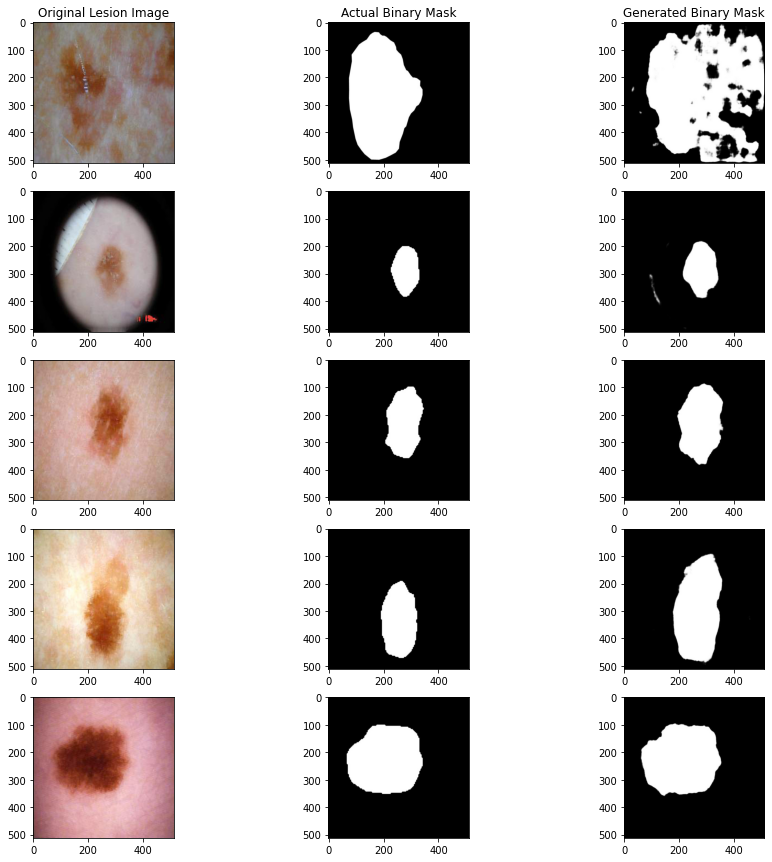

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision.transforms as transforms
from torchvision.utils import save_image
import glob

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from torch.utils.data import Dataset
from PIL import Image
import numpy.matlib

import torch.nn as nn
import torch.nn.functional as F
import torch


def dice_coeff(seg, gt):
    smooth = .0001
    return (np.sum(seg[gt == 1])*2.0 + smooth) / (np.sum(seg) + np.sum(gt) + smooth)

def sample_images(imgs, model, path, idx=None,save=False):
    """Saves a generated sample from the test set"""
    true_map = Variable(imgs['B'].type(Tensor))
    save_image(true_map, os.path.join(path, 'test_results/gt', str(idx)) +'.jpg', normalize=True)
    fake_B = model(Variable(imgs['A'].type(Tensor)))
    if save:
        save_image(fake_B, os.path.join(path, 'test_results/pred_map', str(idx)) +'.jpg', normalize=True)
    return fake_B


def evaluationMetric(image, thresh, path):
    path = os.path.join(path, 'test_results/pred_map/')
    map_GT = Image.open(image)
    map_pred = Image.open(os.path.join(path, image.split('/')[-1]))
    w, h = map_GT.size

    # Binarize the prediction and groundtruth
    true_labels = np.reshape(np.asarray(map_GT)[:,:,1], (w*h,1))
    true_labels = np.where(true_labels > thresh, 1, 0)
    pred_labels = np.reshape(np.asarray(map_pred)[:,:,1], (w*h,1))
    pred_labels = np.where(pred_labels > thresh, 1, 0)

    ##Dice Coeff
    dice = dice_coeff(pred_labels,true_labels)

    return dice

class OptionsUNet:
  def __init__(self, dataset_name = "sgan", n_cpu = 8, img_height = 256, img_width = 256, mod = 3, n_residual_blocks = 6, path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/images"):
    self.dataset_name = dataset_name
    self.n_cpu = n_cpu
    self.img_height = img_height
    self.img_width = img_width
    self.mod = mod
    self.n_residual_blocks = n_residual_blocks
    self.path = path

    return 

opt = OptionsUNet()

transforms_val = [ transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]


val_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val"
val_dataloader = DataLoader(ImageDataset(val_path, transforms_=transforms_val, mode='val'), batch_size=1, shuffle=True, num_workers=1)
print('len of val batch is: ', len(val_dataloader))

# Initialize generator and discriminator
cuda = True if torch.cuda.is_available() else False

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = GeneratorUNet()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()

generator.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model/sgan/generator_49.pth"))
generator.eval()


def main():
    elapse = []
    os.makedirs(os.path.join(opt.path, 'test_results/gt/'), exist_ok=True)
    os.makedirs(os.path.join(opt.path, 'test_results/image/'), exist_ok=True)
    os.makedirs(os.path.join(opt.path, 'test_results/pred_map/'), exist_ok=True)
    for i, image in enumerate(val_dataloader):
        start = time.process_time()
        sample_images(image, generator, opt.path, idx=i, save=True)
        elapsed = (time.process_time() - start)
        elapse.append(elapsed)
        save_image(image['A'], os.path.join(opt.path,'test_results/image/', str(i) +'.jpg'), normalize=True)
    print('Average testing time is ', np.mean(elapse))

    #######################
    
    dice_avg = []
    pred_files = []
    count=0
    disp_count = 0
    for file in sorted(glob.glob(os.path.join(opt.path, 'test_results/gt/*.jpg'))):
        thresh = 200  # grayscale intensity
        dice = evaluationMetric(file, thresh, opt.path)
        dice_avg.append(dice)
        count += 1
        image = file.split("/")
        if disp_count < 5:
          image = file.split("/").pop()
          files = []
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/images/test_results/image", image))
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/images/test_results/gt", image))
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/images/test_results/pred_map", image))
          disp_count += 1
          pred_files.append(files)
        
    print("Average DICE COEFFICIENT: ",sum(dice_avg) / float(len(dice_avg)))

    fig, ax = plt.subplots(5,3,figsize=[15,15])

    ax[0, 0].title.set_text('Original Lesion Image')
    ax[0, 1].title.set_text('Actual Binary Mask')
    ax[0, 2].title.set_text('Generated Binary Mask')

    for idx in range(5):
      ax[idx, 0].imshow(mpimg.imread(pred_files[idx][0]))
      ax[idx, 1].imshow(mpimg.imread(pred_files[idx][1]))
      ax[idx, 2].imshow(mpimg.imread(pred_files[idx][2]))

if __name__ == "__main__":
    main()


#Training of Generator + Discriminator Model

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch

class OptionsUNet:
  def __init__(self, epoch = 194, n_epochs = 200, dataset_name = "GAN", batch_size = 32, lr = 0.00001, b1 = 0.5, b2 = 0.999, decay_epoch = 2, n_cpu = 8, img_height = 256, img_width = 256, 
               channels = 3, sample_interval = 1, checkpoint_interval = 1, path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/train"):
    self.epoch = epoch
    self.n_epochs = n_epochs
    self.dataset_name = dataset_name
    self.batch_size = batch_size
    self.lr = lr
    self.b1 = b1
    self.b2 = b2
    self.decay_epoch = decay_epoch
    self.n_cpu = n_cpu
    self.img_height = img_height
    self.img_width = img_width
    self.channels = channels
    self.sample_interval = sample_interval
    self.checkpoint_interval = checkpoint_interval
    self.path = path

    return 

opt = OptionsUNet()
print(opt)

os.makedirs('images_%s' % opt.dataset_name, exist_ok=True)
os.makedirs('saved_model_%s' % opt.dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Calculate output of image discriminator
patch = (1, opt.img_height//2**5, opt.img_width//2**5)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = PixelDiscriminator()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()
    discriminator = torch.nn.DataParallel(discriminator).cuda()

    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model_GAN/generator_193.pth"))
    discriminator.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model_GAN/discriminator_193.pth"))
else:
    # Initialize weights

    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Configure dataloaders
transforms_ = [transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]
transforms.Resize((opt.img_height, opt.img_width)
transforms_val = [, Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]

train_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/train"
dataloader = DataLoader(ImageDataset(train_path, transforms_=transforms_), batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)
print('len of train batch is: ', len(dataloader))

val_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val"
val_dataloader = DataLoader(ImageDataset(val_path, transforms_=transforms_val, mode='val'), batch_size=1, shuffle=True, num_workers=1)
print('len of val batch is: ', len(val_dataloader))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(epoch, i, path):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs['A'].type(Tensor))
    real_B = Variable(imgs['B'].type(Tensor))
    fake_B = generator(real_A)
    os.makedirs(os.path.join(path,'images_%s/epoch_%s/img/' % (opt.dataset_name, epoch)), exist_ok=True)
    os.makedirs(os.path.join(path,'images_%s/epoch_%s/gt/' % (opt.dataset_name, epoch)), exist_ok=True)
    os.makedirs(os.path.join(path,'images_%s/epoch_%s/pred/' % (opt.dataset_name, epoch)), exist_ok=True)
    save_image(real_A, os.path.join(path,'images_%s/epoch_%s/img/%s_image.png' % (opt.dataset_name, epoch, i)), nrow=3, normalize=True, scale_each=True)
    save_image(real_B, os.path.join(path,'images_%s/epoch_%s/gt/%s_image.png' % (opt.dataset_name, epoch, i)), nrow=3, normalize=True, scale_each=True)
    save_image(fake_B, os.path.join(path,'images_%s/epoch_%s/pred/%s_image.png' % (opt.dataset_name, epoch, i)), nrow=3, normalize=True, scale_each=True)

prev_time = time.time()

for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch['A'].type(Tensor))
        real_B = Variable(batch['B'].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(real_A,fake_B)

        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Loss weight of L1 pixel-wise loss between translated image and real image
        lambda_pixel = 0.99

        # Total loss
        loss_G = (1-lambda_pixel)*loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A,real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write("\n[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" %
                                                        (epoch, opt.n_epochs,
                                                        i, len(dataloader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_pixel.item(), loss_GAN.item(),
                                                        time_left))
        
        # If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            sample_images(epoch, i, opt.path)

    if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), os.path.join(root_path, 'saved_model_%s/generator_%d.pth' % (opt.dataset_name, epoch)))
        torch.save(discriminator.state_dict(), os.path.join(root_path, 'saved_model_%s/discriminator_%d.pth' % (opt.dataset_name, epoch)))

len of train batch is:  82
len of val batch is:  100


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



[Epoch 194/200] [Batch 0/82] [D loss: 0.247998] [G loss: 0.006128, pixel: 0.004695, adv: 0.147985] ETA: 5:20:04.153533
[Epoch 194/200] [Batch 1/82] [D loss: 0.233977] [G loss: 0.005962, pixel: 0.003553, adv: 0.244413] ETA: 3:12:08.440849
[Epoch 194/200] [Batch 2/82] [D loss: 0.226268] [G loss: 0.006776, pixel: 0.003358, adv: 0.345123] ETA: 3:09:17.886357
[Epoch 194/200] [Batch 3/82] [D loss: 0.220224] [G loss: 0.007445, pixel: 0.003600, adv: 0.388143] ETA: 3:05:21.212294
[Epoch 194/200] [Batch 4/82] [D loss: 0.216465] [G loss: 0.006761, pixel: 0.003845, adv: 0.295445] ETA: 3:06:43.670584
[Epoch 194/200] [Batch 5/82] [D loss: 0.236210] [G loss: 0.007101, pixel: 0.003652, adv: 0.348587] ETA: 3:05:09.997281
[Epoch 194/200] [Batch 6/82] [D loss: 0.221178] [G loss: 0.006701, pixel: 0.004510, adv: 0.223640] ETA: 3:05:08.113538
[Epoch 194/200] [Batch 7/82] [D loss: 0.224675] [G loss: 0.007772, pixel: 0.005161, adv: 0.266307] ETA: 3:04:07.847399
[Epoch 194/200] [Batch 8/82] [D loss: 0.255879]

Validation of Generator with Discriminator

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


len of val batch is:  100
Average testing time is  4.689120665400002
Average DICE COEFFICIENT:  0.8788851714867698


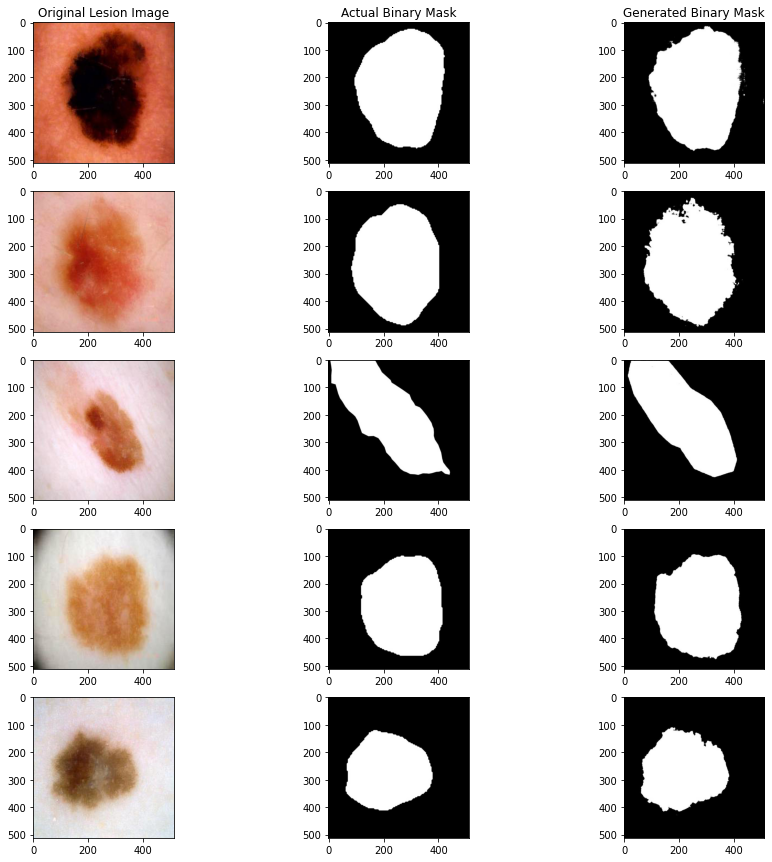

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import torchvision.transforms as transforms
from torchvision.utils import save_image
import glob

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from torch.utils.data import Dataset
from PIL import Image
import numpy.matlib

import torch.nn as nn
import torch.nn.functional as F
import torch


def dice_coeff(seg, gt):
    smooth = .0001
    return (np.sum(seg[gt == 1])*2.0 + smooth) / (np.sum(seg) + np.sum(gt) + smooth)

def sample_images(imgs, model, path, idx=None,save=False):
    """Saves a generated sample from the test set"""
    true_map = Variable(imgs['B'].type(Tensor))
    save_image(true_map, os.path.join(path, 'test_results/gt', str(idx)) +'.jpg', normalize=True)
    fake_B = model(Variable(imgs['A'].type(Tensor)))
    if save:
        save_image(fake_B, os.path.join(path, 'test_results/pred_map', str(idx)) +'.jpg', normalize=True)
    return fake_B


def evaluationMetric(image, thresh, path):
    path = os.path.join(path, 'test_results/pred_map/')
    map_GT = Image.open(image)
    map_pred = Image.open(os.path.join(path, image.split('/')[-1]))
    w, h = map_GT.size

    # Binarize the prediction and groundtruth
    true_labels = np.reshape(np.asarray(map_GT)[:,:,1], (w*h,1))
    true_labels = np.where(true_labels > thresh, 1, 0)
    pred_labels = np.reshape(np.asarray(map_pred)[:,:,1], (w*h,1))
    pred_labels = np.where(pred_labels > thresh, 1, 0)

    ##Dice Coeff
    dice = dice_coeff(pred_labels,true_labels)

    return dice

class OptionsUNet:
  def __init__(self, dataset_name = "ISIC_2018", n_cpu = 8, img_height = 256, img_width = 256, mod = 3, n_residual_blocks = 6, path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val"):
    self.dataset_name = dataset_name
    self.n_cpu = n_cpu
    self.img_height = img_height
    self.img_width = img_width
    self.mod = mod
    self.n_residual_blocks = n_residual_blocks
    self.path = path

    return 

opt = OptionsUNet()

transforms_val = [ transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]


val_path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val"
val_dataloader = DataLoader(ImageDataset(val_path, transforms_=transforms_val, mode='val'), batch_size=1, shuffle=True, num_workers=1)
print('len of val batch is: ', len(val_dataloader))

# Initialize generator and discriminator
cuda = True if torch.cuda.is_available() else False

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = GeneratorUNet()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()

generator.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model_GAN/generator_199.pth"))
generator.eval()


def main():
    elapse = []
    os.makedirs(os.path.join(opt.path, 'test_results/gt/'), exist_ok=True)
    os.makedirs(os.path.join(opt.path, 'test_results/image/'), exist_ok=True)
    os.makedirs(os.path.join(opt.path, 'test_results/pred_map/'), exist_ok=True)
    for i, image in enumerate(val_dataloader):
        start = time.process_time()
        sample_images(image, generator, opt.path, idx=i, save=True)
        elapsed = (time.process_time() - start)
        elapse.append(elapsed)
        save_image(image['A'], os.path.join(opt.path,'test_results/image/', str(i) +'.jpg'), normalize=True)
    print('Average testing time is ', np.mean(elapse))

    #######################
    
    dice_avg = []
    pred_files = []
    count=0
    disp_count = 0
    for file in sorted(glob.glob("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val/test_results/gt/*.jpg")):
        thresh = 200  # grayscale intensity
        dice = evaluationMetric(file, thresh, opt.path)
        image = file.split("/")
        if dice > 0.95 and disp_count < 5:
          image = file.split("/").pop()
          files = []
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val/test_results/image", image))
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val/test_results/gt", image))
          files.append(os.path.join("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/val/test_results/pred_map", image))
          pred_files.append(files)
          disp_count += 1
        dice_avg.append(dice)
        count += 1
    print("Average DICE COEFFICIENT: ",sum(dice_avg) / float(len(dice_avg)))

    fig, ax = plt.subplots(5,3,figsize=[15,15])

    ax[0, 0].title.set_text('Original Lesion Image')
    ax[0, 1].title.set_text('Actual Binary Mask')
    ax[0, 2].title.set_text('Generated Binary Mask')

    for idx in range(5):
      ax[idx, 0].imshow(mpimg.imread(pred_files[idx][0]))
      ax[idx, 1].imshow(mpimg.imread(pred_files[idx][1]))
      ax[idx, 2].imshow(mpimg.imread(pred_files[idx][2]))

if __name__ == "__main__":
    main()


#Generating Binary Masks - Testing

In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image
import glob

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from torch.utils.data import Dataset
from PIL import Image
#from models import GeneratorUNet

#from datasets import ImageDataset
import numpy.matlib

import torch.nn as nn
import torch.nn.functional as F
import torch

def sample_images(imgs, model, path, idx=None,save=False):
    """Saves a generated sample from the test set"""
    fake_B = model(Variable(imgs['A'].type(Tensor)))
    if save:
        save_image(fake_B, os.path.join(path, 'test_results/pred_map', str(idx)) +'.jpg', normalize=True)
    return fake_B

class OptionsUNet:
  def __init__(self, dataset_name = "ISIC_2018", n_cpu = 8, img_height = 256, img_width = 256, mod = 3, n_residual_blocks = 6, path = "/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/test"):
    self.dataset_name = dataset_name
    self.n_cpu = n_cpu
    self.img_height = img_height
    self.img_width = img_width
    self.mod = mod
    self.n_residual_blocks = n_residual_blocks
    self.path = path

    return 

opt = OptionsUNet()

transforms_ = [ transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))]

test_dataloader = DataLoader(ImageDataset(opt.path, transforms_=transforms_, mode="test"),
                          batch_size=1, shuffle=False, num_workers=1)

print("Number of test images = ", len(test_dataloader))
# Initialize generator and discriminator
cuda = True if torch.cuda.is_available() else False

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = GeneratorUNet()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()

generator.load_state_dict(torch.load("/content/gdrive/MyDrive/ISIC_DATASETS/ISIC_Datasets/GAN/saved_model_GAN/generator_199.pth"))
generator.eval()


def main():
    elapse = []
    os.makedirs(os.path.join(opt.path, 'test_results/image/'), exist_ok=True)
    os.makedirs(os.path.join(opt.path, 'test_results/pred_map/'), exist_ok=True)
    for i, image in enumerate(test_dataloader):
        print(i, end=" ")
        start = time.process_time()
        sample_images(image, generator, opt.path, idx=i, save=True)
        elapsed = (time.process_time() - start)
        elapse.append(elapsed)
        save_image(image['A'], os.path.join(opt.path,'test_results/image/', str(i) +'.jpg'), normalize=True)
        print("saved")
    print('\nAverage testing time is ', np.mean(elapse))

if __name__ == "__main__":
    main()


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Streaming output truncated to the last 5000 lines.
6722 saved
6723 saved
6724 saved
6725 saved
6726 saved
6727 saved
6728 saved
6729 saved
6730 saved
6731 saved
6732 saved
6733 saved
6734 saved
6735 saved
6736 saved
6737 saved
6738 saved
6739 saved
6740 saved
6741 saved
6742 saved
6743 saved
6744 saved
6745 saved
6746 saved
6747 saved
6748 saved
6749 saved
6750 saved
6751 saved
6752 saved
6753 saved
6754 saved
6755 saved
6756 saved
6757 saved
6758 saved
6759 saved
6760 saved
6761 saved
6762 saved
6763 saved
6764 saved
6765 saved
6766 saved
6767 saved
6768 saved
6769 saved
6770 saved
6771 saved
6772 saved
6773 saved
6774 saved
6775 saved
6776 saved
6777 saved
6778 saved
6779 saved
6780 saved
6781 saved
6782 saved
6783 saved
6784 saved
6785 saved
6786 saved
6787 saved
6788 saved
6789 saved
6790 saved
6791 saved
6792 saved
6793 saved
6794 saved
6795 saved
6796 saved
6797 saved
6798 saved
6799 saved
6800 saved
6801 saved
6802 saved
6803 saved
6804 saved
6805 saved
6806 saved
6807 saved
680